MODEL TRAINING

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import joblib


Leemos el dataset limpio

In [4]:
df = pd.read_csv('../data/MLA_100k_clean.csv')

Revisamos las columnas que hay en el dataset para luego generar los modelos.

In [5]:
df.head()

,condition,base_price,price,buying_mode,last_updated,accepts_mercadopago,date_created,stop_time,status,initial_quantity,start_time,sold_quantity,available_quantity
0,1,80.0,80.0,buy_it_now,20150905,True,20150905,20151104,active,1,20150905,0,1
1,0,2650.0,2650.0,buy_it_now,20150926,True,20150926,20151125,active,1,20150926,0,1
2,0,60.0,60.0,buy_it_now,20150909,True,20150909,20151108,active,1,20150909,0,1
3,1,580.0,580.0,buy_it_now,20151005,True,20150928,20151204,active,1,20150928,0,1
4,0,30.0,30.0,buy_it_now,20150828,True,20150824,20151023,active,1,20150824,0,1


Convertir variables categóricas a variables dummy (One-Hot Encoding)

In [6]:
# Convertir variables categóricas a variables dummy (One-Hot Encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

# Definir X (todas las columnas excepto la columna objetivo) e y (columna objetivo)
X = df_encoded.drop('condition', axis=1) 
y = df_encoded['condition']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


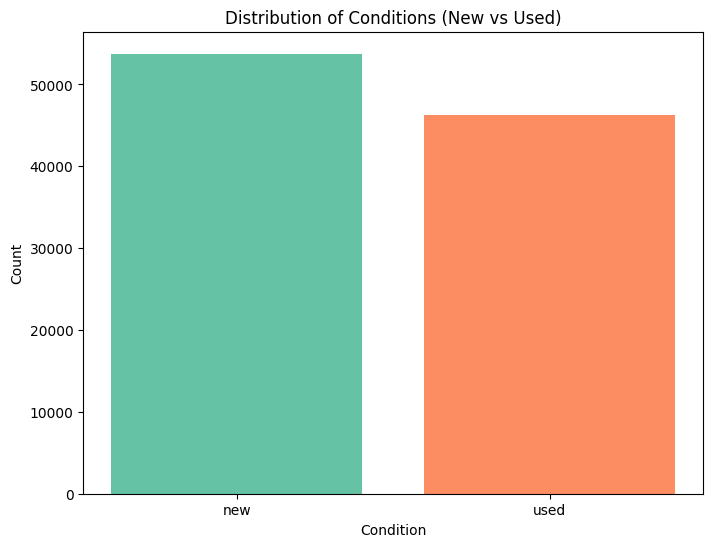

In [7]:
# Reemplazar los valores de 'condition' con las etiquetas 'new' y 'used'
df['condition'] = df['condition'].map({1: 'new', 0: 'used'})

# Contar la cantidad de cada categoría
condition_counts = df['condition'].value_counts()
colors = sns.color_palette('Set2')[0:len(condition_counts)]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(condition_counts.index, condition_counts.values, color=colors)
plt.title('Distribution of Conditions (New vs Used)')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

Este gráfico de barras indica que en el conjunto de datos hay una mayor cantidad de productos nuevos que usados. Aunque la diferencia no es enorme, sí se observa una tendencia hacia una oferta más alta de productos nuevos en comparación con los usados.

generar los modelos de predicción utilizando diferentes algoritmos: Regresión Logística, RandomForestClassifier, XGBClassifier, Gradient Boosting y K-Nearest Neighbors (KNN).

#### Entrenamos los Modelos

Regresión Logística


In [8]:

# Entrenar el modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Hacer predicciones
y_pred_log = log_reg.predict(X_test)

# Calcular la precisión
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f'Accuracy Logistic Regression: {accuracy_log}')

Accuracy Logistic Regression: 0.7095


RandomForestClassifier

In [9]:
# Crear el modelo Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_clf.fit(X_train, y_train)

# Hacer predicciones
y_pred_rf = rf_clf.predict(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy Random Forest: {accuracy_rf}')


Accuracy Random Forest: 0.76685


XGBClassifier

In [10]:
# Crear el modelo XGBoost
xgb_clf = XGBClassifier(eval_metric='mlogloss')

# Entrenar el modelo
xgb_clf.fit(X_train, y_train)

# Hacer predicciones
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluar el modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy XGBoost: {accuracy_xgb}')


Accuracy XGBoost: 0.78515


Gradient Boosting

In [11]:
# Entrenar Gradient Boosting
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)

# Evaluar Gradient Boosting
print("Gradient Boosting - Accuracy:", accuracy_score(y_test, y_pred_gb))

Gradient Boosting - Accuracy: 0.76995


K-Nearest Neighbors (KNN)

In [12]:
# Entrenar KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

# Evaluar KNN
print("KNN - Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN - Accuracy: 0.72995


Comparar los resultados

In [13]:
print(f'Accuracy Logistic Regression: {accuracy_log}')
print(f'Accuracy Random Forest: {accuracy_rf}')
print(f'Accuracy XGBoost: {accuracy_xgb}')
print("Accuracy Gradient Boosting:", accuracy_score(y_test, y_pred_gb))
print("Accuracy KNN:", accuracy_score(y_test, y_pred_knn))

Accuracy Logistic Regression: 0.7095
Accuracy Random Forest: 0.76685
Accuracy XGBoost: 0.78515
Accuracy Gradient Boosting: 0.76995
Accuracy KNN: 0.72995


Despues de entrenar los cinco modelos: Regresión Logística, RandomForestClassifier, XGBClassifier, Gradient Boosting y K-Nearest Neighbors (KNN). Para seleccionar el mejor, usamos la métrica de accuracy.

En este caso el modelo de XGBoost ha tenido el mejor rendimiento en términos de accuracy (0.78515).
Esto indica que es el más eficaz para clasificar correctamente las instancias en el conjunto de datos.

### Guardar el modelo XGBoost como archivo .pkl

In [21]:
joblib.dump(xgb_clf, '../Model/modelo_xgboost.pkl')

print("Modelo XGBoost guardado como 'modelo_xgboost.pkl'")

Modelo XGBoost guardado como 'modelo_xgboost.pkl'


Gráfico de variables influyentes en el comportamiento del modelo.

C:\Users\MAFE\AppData\Local\Temp\ipykernel_1772\2509384591.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


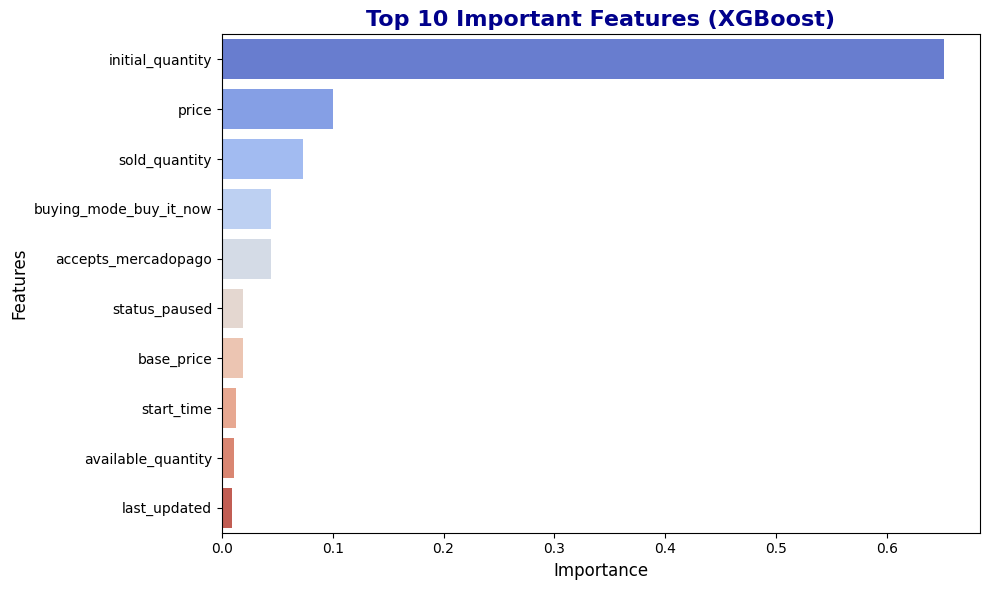

In [15]:

# Obtener las importancias de las características del modelo XGBoost entrenado
importances = xgb_clf.feature_importances_

# Crear un DataFrame para visualizar mejor las importancias
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar las características por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)  # Top 10

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')

# Personalizar el título y etiquetas
plt.title('Top 10 Important Features (XGBoost)', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

La característica más influyente en el modelo es 'initial_quantity', con una importancia cercana a 0.6. Esto significa que tiene un papel crucial en las decisiones del modelo. En general, mientras mayor sea el valor de importancia de una característica, más relevante es para el rendimiento del modelo. Esto implica que cualquier variación en 'initial_quantity' puede afectar considerablemente las predicciones generadas por el modelo.

Gráfico de distribución de precios según la condición del producto (nuevo o usado).

C:\Users\MAFE\AppData\Local\Temp\ipykernel_1772\3810672000.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='price', data=df, palette='Set2')


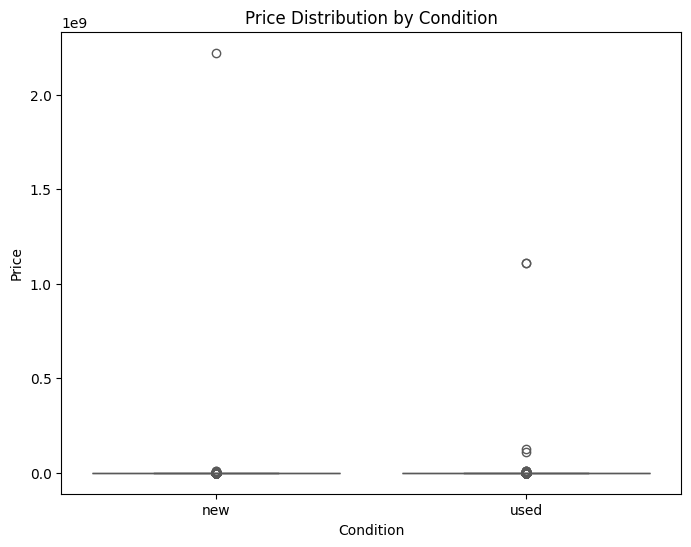

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='condition', y='price', data=df, palette='Set2')
plt.title('Price Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.show()


Este gráfico muestra que la mayoría de los productos, tanto nuevos como usados, tienen precios muy bajos, pero hay algunos con precios extremadamente altos (outliers). No se observan grandes diferencias en la distribución central de precios entre productos nuevos y usados.

Gráfico de barras para el modo de compra.

C:\Users\MAFE\AppData\Local\Temp\ipykernel_1772\235508751.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='buying_mode', data=df, palette='Set2')


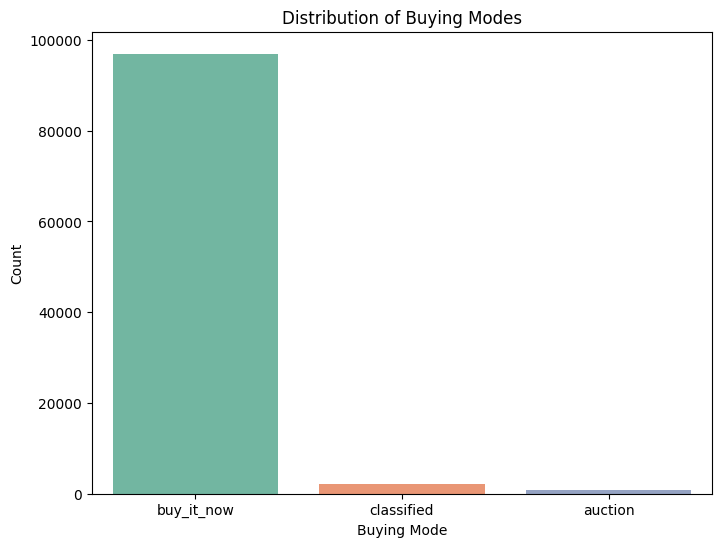

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(x='buying_mode', data=df, palette='Set2')
plt.title('Distribution of Buying Modes')
plt.xlabel('Buying Mode')
plt.ylabel('Count')
plt.show()


Este gráfico muestra que la gran mayoría de los productos se venden bajo la modalidad de "buy it now", mientras que las opciones de "classified" y "auction" no son tan comunes.

 Relación entre dos variables numéricas: Precio y la cantidad inicial de productos.

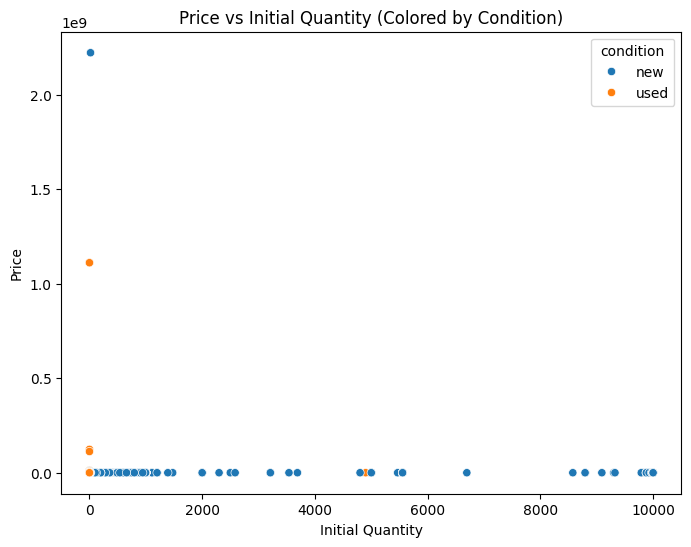

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='initial_quantity', y='price', data=df, hue='condition')
plt.title('Price vs Initial Quantity (Colored by Condition)')
plt.xlabel('Initial Quantity')
plt.ylabel('Price')
plt.show()


Este gráfico muestra la relación entre el precio y la cantidad inicial de productos, diferenciando entre productos nuevos (en azul) y usados (en naranja). La mayoría de los productos tienen un precio bajo y cantidades iniciales relativamente pequeñas. Sin embargo, hay algunos puntos atípicos con precios extremadamente altos. La mayoría de estos puntos corresponden a productos nuevos.